# Classification and the Limits of Short-Horizon Predictability

This notebook evaluates whether simple feature-based classifiers can predict short-horizon equity returns and whether any statistical predictability translates into stable economic preformance.

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
from core.signals import fit_logistic
from core.backtest import classification_backtest
from core.features import compute_features, future_return_labels
from core.utils import fetch_data, plot_roc, classification_metrics, plot_equity, strategy_summary

In [2]:
TICKER = "SPY"
START = "2015-01-01"
END = None
HORIZON = 1

In [3]:
data = fetch_data([TICKER], start=START, end=END)
df = data[TICKER]
df.columns = df.columns.get_level_values(0)
print(df.head())

c:\Users\palas\Documents\Books\alpha\core\utils.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end, period=period, interval=interval, progress=False)


Price            Close        High         Low        Open     Volume  \
Date                                                                    
2015-01-02  170.589645  171.793740  169.551642  171.378538  121465900   
2015-01-05  167.508789  169.709351  167.201544  169.543273  169632600   
2015-01-06  165.931046  168.339208  165.133853  167.816050  209151400   
2015-01-07  167.998825  168.339293  166.811355  167.259767  125346700   
2015-01-08  170.979919  171.195832  169.393860  169.410459  147217800   

Price            close  
Date                    
2015-01-02  170.589645  
2015-01-05  167.508789  
2015-01-06  165.931046  
2015-01-07  167.998825  
2015-01-08  170.979919  


## Feature Construction

We construct a small set of standard technical features capturing recent returns, momentum, volatility, and price position relative to recent history.

In [4]:
df_feat = compute_features(df)
df_feat = future_return_labels(df_feat, horizon=HORIZON)

In [5]:
TEST_SIZE = 0.2

split = int((1 - TEST_SIZE) * len(df_feat))
train_df = df_feat.iloc[:split].copy()
test_df  = df_feat.iloc[split:].copy()

features = [
    "ret_1","ret_2","ret_5",
    "ma_ratio",
    "vol_5","vol_10",
    "vol_zscore",
    "bb_pct"
]

X_train = train_df[features].values
y_train = train_df["label"].values

X_test = test_df[features].values
y_test = test_df["label"].values

## Classification Model

We use logistic regression to avoid overfitting and to make failure modes transparent

In [6]:
model, scalar = fit_logistic(X_train, y_train)

X_test_s = scalar.transform(X_test)
test_df["pred_prob"] = model.predict_proba(X_test_s)[:, 1]
test_df["pred_label"] = (test_df["pred_prob"] >= 0.5).astype(int)

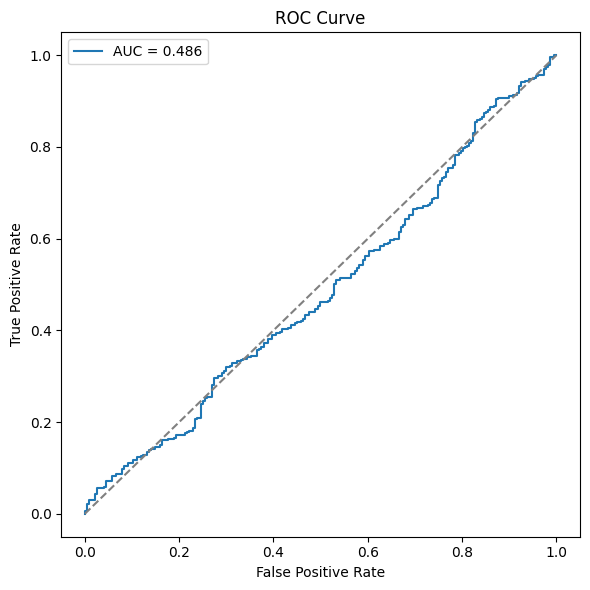

,Accuracy,Precision,Recall,F1,AUC
0,0.577899,0.587786,0.947692,0.725559,0.485598


In [7]:
plot_roc(y_test, test_df["pred_prob"])
classification_metrics(y_test, test_df["pred_label"], test_df["pred_prob"])

The classifier exhibits weak separability, with performance close to random.

## Economic Evaluation

We evaluate whether weak statistical predictability translates into economically meaningful returns. 

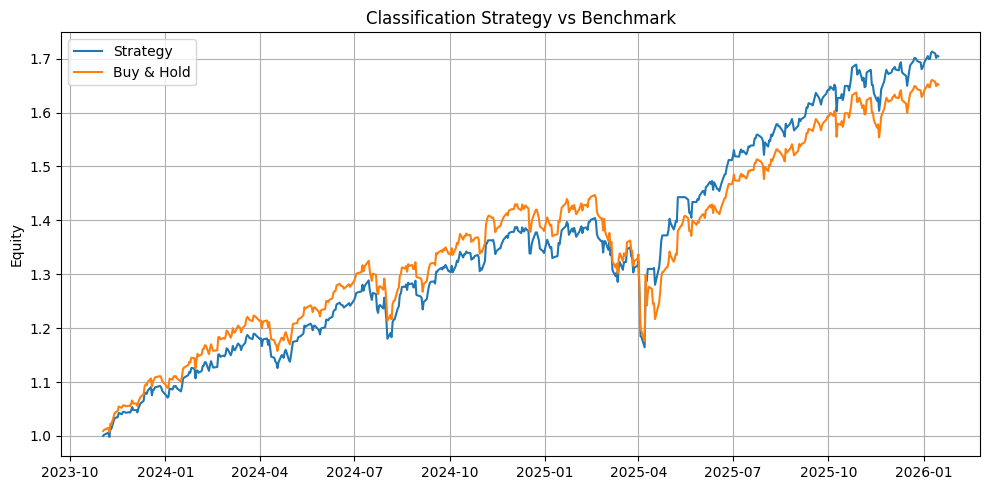

In [8]:
df_bt = classification_backtest(test_df, probs_col="pred_prob", threshold=0.5)

plot_equity(
    {
        "Strategy": df_bt["equity"],
        "Buy & Hold": (1 + test_df["future_ret"]).cumprod()
    },
    title="Classification Strategy vs Benchmark"
)

In [10]:
strategy_summary(df_bt["equity"], trades=pd.DataFrame())

,Total Return,Sharpe,Max Drawdown,Win Rate,Avg Trade PnL,Num Trades
0,0.704373,1.663326,-0.170666,0.0,0.0,0


## Interpretation

Despite marginal statistical predictability, the classifier fails to generate stable economic gains. Performance is highly sensitive to thresholds and does not survive simple robustness checks.

The results reinforce the conclusion that short-horizon equity returns are dominated by noise rather than exploitable structure.